In [94]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import numpy as np
from pysas import World, waveread
from pysas.mcep import spec2mcep_from_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Speech analysis and synthesis with World

In [159]:
signal, samplingrate, _ = waveread("test/cmu_arctic/arctic_a0001.wav")  # from http://festvox.org/cmu_arctic/dbs_bdl.html

In [3]:
world = World(samplingrate)

In [97]:
f0, spec_mat, aperiod_mat = world.analyze(signal)

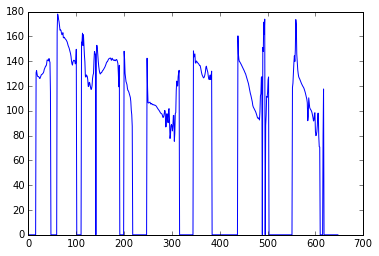

In [98]:
plt.plot(f0)

In [99]:
spec = spec_mat[300]

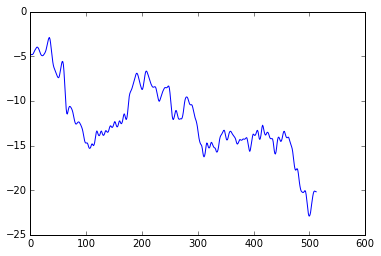

In [100]:
plt.plot(np.log(spec))

In [117]:
out = world.synthesis(f0, spec_mat, aperiod_mat)

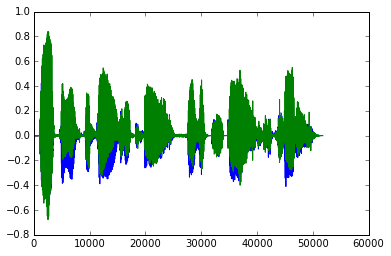

In [118]:
plt.plot(signal)
plt.plot(out)

# Mel-Cepstrum Analysis

In [125]:
from pysas.mcep import spec2mcep, mcep2spec, mcep2coef, coef2mcep, estimate_alpha

In [121]:
alpha = round(estimate_alpha(samplingrate), 3) 
alpha

0.41

In [122]:
mcep = spec2mcep(spec, 24, alpha)

In [123]:
spec2 = mcep2spec(mcep, alpha, world.fftsize())

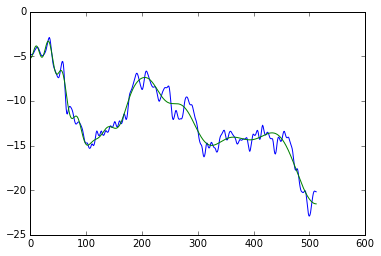

In [124]:
plt.plot(np.log(spec))
plt.plot(np.log(spec2[:world.envelopesize()]))

## from fft

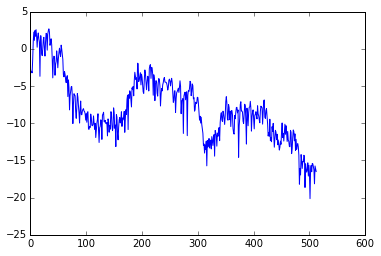

In [126]:
i = 80* 300
windowsize = 1024
sig = signal[i:i+windowsize] * np.hanning(windowsize)
power_spectrum = (np.absolute(np.fft.fft(sig)) ** 2)[:(windowsize>>1) + 1]
plt.plot(np.log(power_spectrum))

In [127]:
fft_mcep = spec2mcep(power_spectrum, 20, alpha)
reconst_pspec = mcep2spec(fft_mcep, alpha, windowsize)

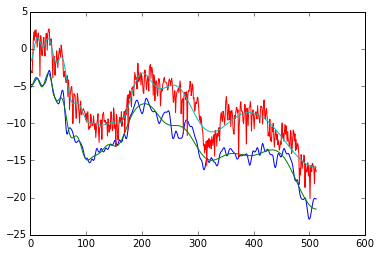

In [128]:
plt.plot(np.log(spec))
plt.plot(np.log(spec2))
plt.plot(np.log(power_spectrum))
plt.plot(np.log(reconst_pspec))

## Convert Mel-Cepstrum to Coefficients for MLSA Degital Filter

In [129]:
coef = mcep2coef(fft_mcep, alpha)
reconst_mcep = coef2mcep(coef, alpha)

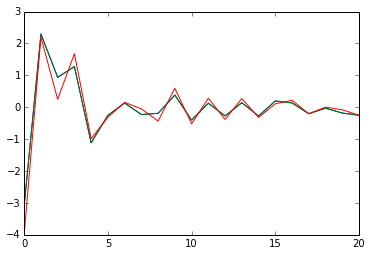

In [130]:
plt.plot(fft_mcep)
plt.plot(reconst_mcep)
plt.plot(coef)

## Generate excited pulse from F0 sequence

In [131]:
from pysas.excite import ExcitePulse

In [114]:
ep = ExcitePulse(16000, 80, False)

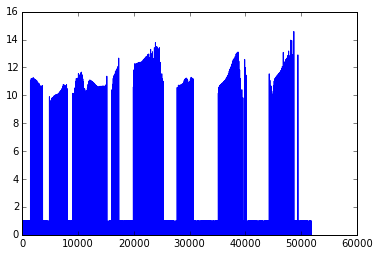

In [115]:
plt.plot(ep.gen(f0))

# Speech Synthesis WIth Mel-Cepstrum Analysis and MLSA Filter

In [139]:
from pysas.synthesis_filter.mlsa import MLSAFilter
from pysas.synthesis_filter.synthesis import Synthesis
from pysas.mcep import spec2mcep_from_matrix

In [140]:
mlsa = MLSAFilter(40, 0.41, 5)

In [141]:
pulse = ep.gen(f0)

In [142]:
mcep_mat = spec2mcep_from_matrix(spec_mat, 40, 0.41)

In [143]:
coef_mat = []
for i in range(mcep_mat.shape[0]):
    coef_mat.append(mcep2coef(mcep_mat[i], 0.41))
coef_mat = np.array(coef_mat)

In [144]:
syn = Synthesis(80, mlsa)

In [168]:
synth = syn.synthesis(pulse, coef_mat)
synth[:80] = 0

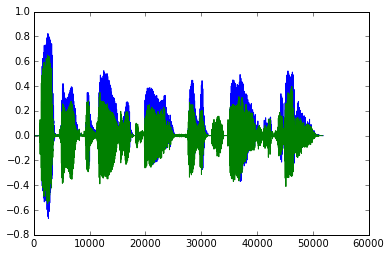

In [169]:
plt.plot(synth)
plt.plot(signal)

### Original

In [170]:
display(Audio(data=np.int16(signal * 32767.0), rate=16000))

### Synthesized

In [171]:
display(Audio(data=np.int16(synth * 32767.0), rate=16000))